In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import DenseNet121
from sklearn.model_selection import train_test_split

In [2]:
x = np.load('/content/drive/MyDrive/N/resized_images.npy')
y = np.load('/content/drive/MyDrive/N/labels.npy')

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

# Create DenseNet base
input_shape = x_train.shape[1:]  # Assuming x_train is a numpy array of images
input_shape

(128, 128, 3)

In [3]:
print(x_train.shape)
print(x_test.shape)

(2200, 128, 128, 3)
(550, 128, 128, 3)


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_resnet50_base(input_shape):
    # Load ResNet50 model without the top layer
    base_model = ResNet50(include_top=False, input_shape=input_shape)

    # Perform global average pooling
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a dense layer with 125 sigmoid activated neurons
    x = Dense(125, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_classification_model(base_model, num_classes):
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Add a dense layer with softmax activation for classification
    x = Dense(num_classes, activation='softmax')(base_model.output)

    # Create the classification model
    model = Model(inputs=base_model.input, outputs=x)

    return model

base_model = create_resnet50_base(input_shape)

num_classes = 5  # Change this to the number of classes in your classification task
classification_model = create_classification_model(base_model, num_classes)

classification_model.summary()


94765736/94765736 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                       

In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("/content/drive/MyDrive/N/res.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = classification_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/25
69/69 [==============================] - ETA: 0s - loss: 1.3334 - accuracy: 0.4232
Epoch 1: val_loss improved from inf to 3.15047, saving model to /content/drive/MyDrive/N/res.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 57s 219ms/step - loss: 1.3334 - accuracy: 0.4232 - val_loss: 3.1505 - val_accuracy: 0.1873 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - ETA: 0s - loss: 1.0825 - accuracy: 0.5309
Epoch 2: val_loss did not improve from 3.15047
69/69 [==============================] - 9s 123ms/step - loss: 1.0825 - accuracy: 0.5309 - val_loss: 3.1620 - val_accuracy: 0.2382 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.6168
Epoch 3: val_loss improved from 3.15047 to 2.67401, saving model to /content/drive/MyDrive/N/res.h5
69/69 [==============================] - 14s 201ms/step - loss: 0.9158 - accuracy: 0.6168 - val_loss: 2.6740 - val_accuracy: 0.3473 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - ETA: 0s - loss: 0.8111 - accuracy: 0.6777
Epoch 4: val_loss improved from 2.67401 to 2.07170, saving model to /content/drive/MyDrive/N/res.h5
69/69 [==============================

In [6]:
classification_model.load_weights("/content/drive/MyDrive/N/res.h5")
classification_model.evaluate(x_test, y_test)

18/18 [==============================] - 1s 37ms/step - loss: 1.0983 - accuracy: 0.7000


[1.0982881784439087, 0.699999988079071]

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming classification_model.predict returns probabilities or predicted classes
y_pred = classification_model.predict(x_test)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)

# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)


18/18 [==============================] - 1s 30ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.73684   0.77064   0.75336       109
           1    0.83186   0.80342   0.81739       117
           2    0.75962   0.76699   0.76329       103
           3    0.57265   0.59292   0.58261       113
           4    0.59804   0.56481   0.58095       108

    accuracy                        0.70000       550
   macro avg    0.69980   0.69976   0.69952       550
weighted avg    0.70033   0.70000   0.69990       550



18/18 [==============================] - 1s 28ms/step


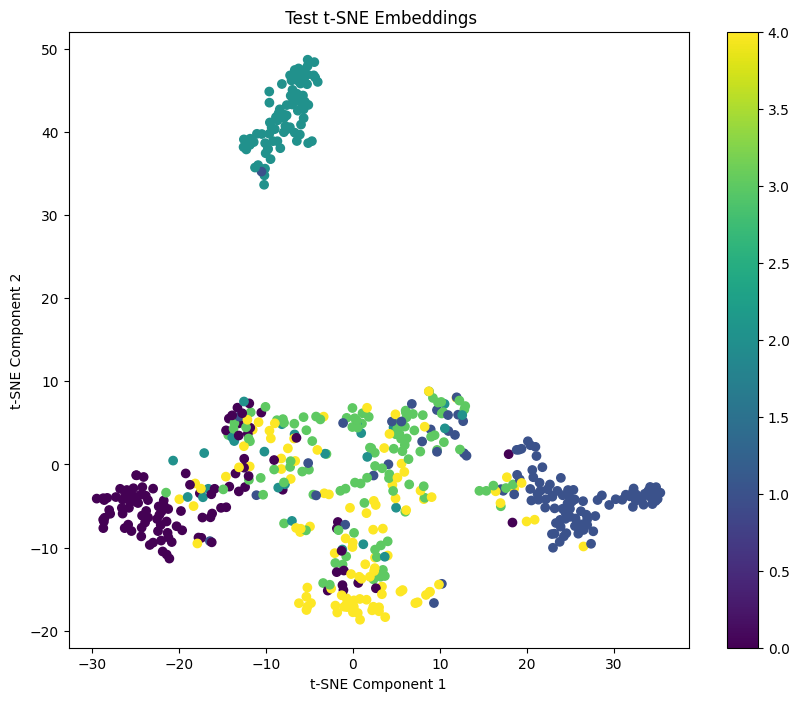

In [8]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


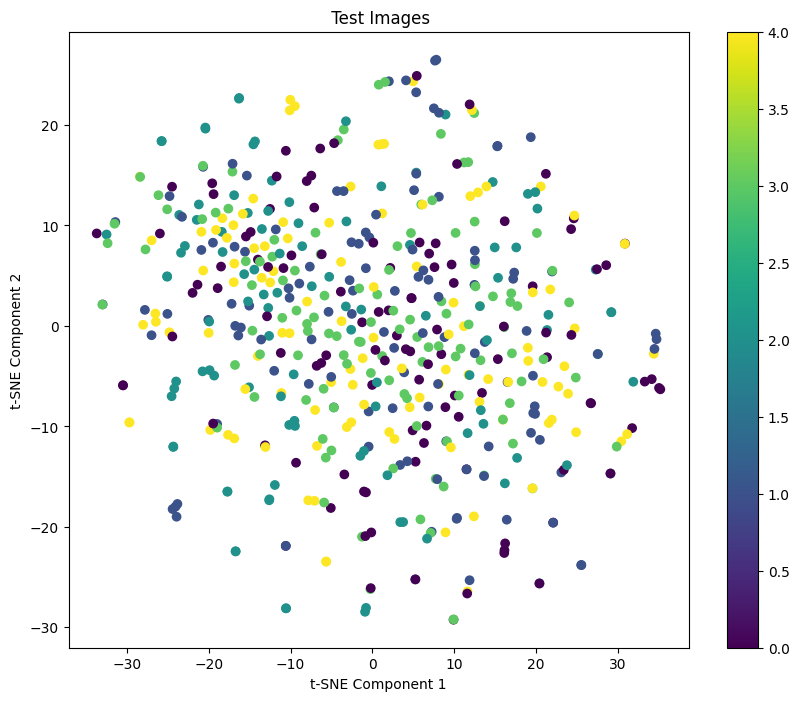

In [9]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
x_test_flat = x_test.reshape((550, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_test_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


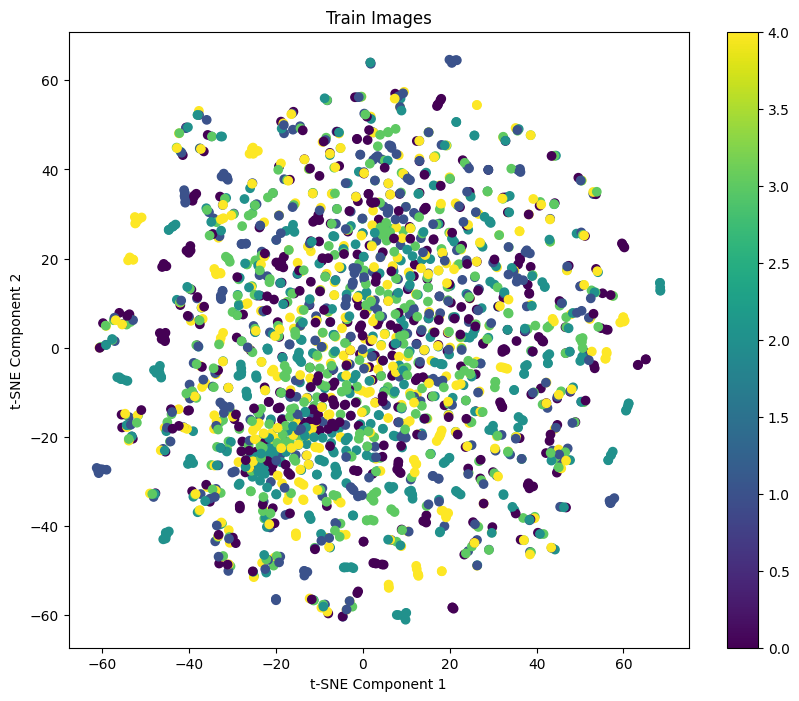

In [10]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
x_train_flat = x_train.reshape((2200, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_train_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


69/69 [==============================] - 2s 29ms/step


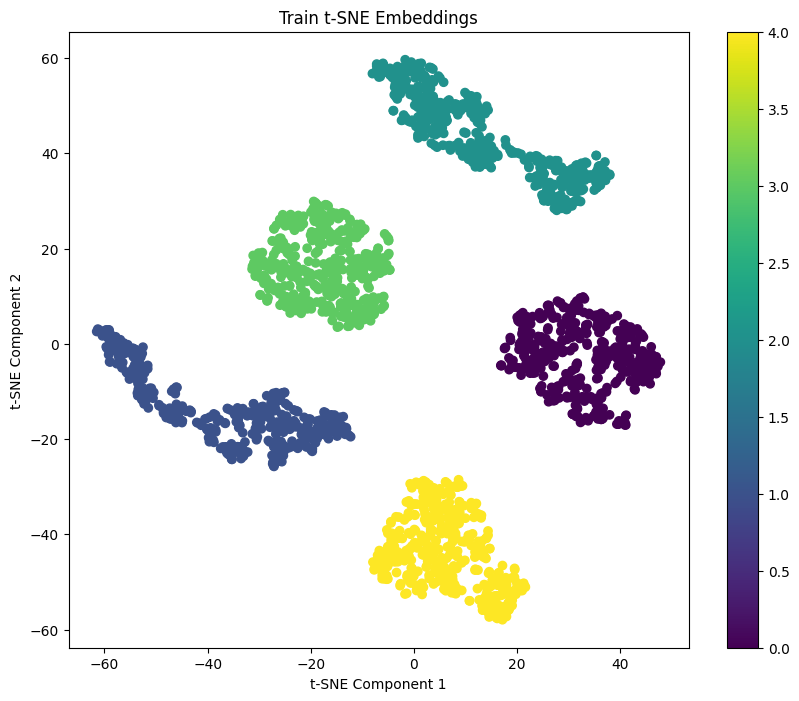

In [11]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


<h1>E-Mixup

In [12]:
xtest_emb = base_model.predict(x_test)
xtrain_emb = base_model.predict(x_train)

69/69 [==============================] - 2s 28ms/step


In [13]:
import keras
y_test_o = keras.utils.to_categorical(y_test)
y_train_o = keras.utils.to_categorical(y_train)
print(y_train_o.shape)
print(y_test_o.shape)

(2200, 5)
(550, 5)


In [14]:
def mixup(xt, yt, mf):
  alp = 0.2
  xaug = []
  yaug = []
  for k in range(0,xt.shape[0]):
    cnt = 0
    for cnt in range(0,mf-1):
      lbd = np.random.beta(alp,alp)
      yks = np.random.randint(xt.shape[0])
      kdash = xt[yks]
      ydash = yt[yks]
      kdash1 = xt[k]
      ydash1 = yt[k]
      xaug1 = kdash1*lbd + kdash*(1-lbd)
      yaug1 = ydash1*lbd + ydash*(1-lbd)
      xaug.append(xaug1)
      yaug.append(yaug1)
  xs2 = np.asarray(xaug)
  ys2 = np.asarray(yaug)
  x1 = np.concatenate((xt,xs2))
  y1 = np.concatenate((yt,ys2))
  return x1,y1

In [15]:
xtrain_emb.shape

(2200, 125)

In [16]:
xtt, ytt = mixup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 3s 6ms/step - loss: 0.1918 - accuracy: 0.9870 - val_loss: 0.9828 - val_accuracy: 0.6927
Epoch 2/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1532 - accuracy: 0.9883 - val_loss: 1.0021 - val_accuracy: 0.6836
Epoch 3/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1432 - accuracy: 0.9873 - val_loss: 1.0341 - val_accuracy: 0.6909
Epoch 4/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1383 - accuracy: 0.9874 - val_loss: 1.0635 - val_accuracy: 0.6945
Epoch 5/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1359 - accuracy: 0.9880 - val_loss: 1.0825 - val_accuracy: 0.6873
Epoch 6/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1336 - accuracy: 0.9894 - val_loss: 1.1428 - val_accuracy: 0.6855
Epoch 7/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1330 - accuracy: 0.9864 - val_loss: 1.1787 - val_accuracy: 0.6782
Epoch 

In [18]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 2ms/step - loss: 1.3223 - accuracy: 0.6909


[1.3222525119781494, 0.6909090876579285]

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.80392   0.75229   0.77725       109
           1    0.80702   0.78632   0.79654       117
           2    0.71053   0.78641   0.74654       103
           3    0.56604   0.53097   0.54795       113
           4    0.57018   0.60185   0.58559       108

    accuracy                        0.69091       550
   macro avg    0.69154   0.69157   0.69077       550
weighted avg    0.69232   0.69091   0.69085       550



E-Stitchup

In [20]:
import numpy as np

def stichup(xt, yt, mf):
    alp = 0.2
    xaug = []
    yaug = []
    for k in range(xt.shape[0]):
        for _ in range(mf-1):  # Renamed loop counter to avoid confusion with loop index
            lbd = np.random.beta(alp, alp)
            yks = np.random.randint(xt.shape[0])
            kdash = xt[yks]  # Accessing rows of xt directly
            ydash = yt[yks]  # Accessing corresponding y value
            kdash1 = xt[k]    # Accessing rows of xt directly
            ydash1 = yt[k]    # Accessing corresponding y value
            lbd_stch = int(xt.shape[1] * lbd)
            reff_stich = np.zeros(xt.shape[1])
            for i in range(lbd_stch):
                index_stich = np.random.randint(xt.shape[1])
                reff_stich[index_stich] = 1
            xaug1 = np.zeros(xt.shape[1])  # Initialize as numpy array
            for i in range(len(reff_stich)):
                if reff_stich[i] == 0:
                    xaug1[i] = kdash[i]
                else:
                    xaug1[i] = kdash1[i]
            yaug1 = ydash1 * lbd + ydash * (1 - lbd)
            xaug.append(xaug1)
            yaug.append(yaug1)
    xs2 = np.asarray(xaug)
    ys2 = np.asarray(yaug)
    x1 = np.concatenate((xt, xs2))
    y1 = np.concatenate((yt, ys2))
    return x1, y1


In [21]:
xtt, ytt = stichup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 2s 4ms/step - loss: 0.2714 - accuracy: 0.9370 - val_loss: 1.1129 - val_accuracy: 0.7000
Epoch 2/25
207/207 [==============================] - 1s 4ms/step - loss: 0.2299 - accuracy: 0.9526 - val_loss: 1.1483 - val_accuracy: 0.6964
Epoch 3/25
207/207 [==============================] - 1s 4ms/step - loss: 0.2177 - accuracy: 0.9548 - val_loss: 1.0569 - val_accuracy: 0.7036
Epoch 4/25
207/207 [==============================] - 1s 5ms/step - loss: 0.2091 - accuracy: 0.9594 - val_loss: 1.1009 - val_accuracy: 0.6927
Epoch 5/25
207/207 [==============================] - 1s 5ms/step - loss: 0.2038 - accuracy: 0.9608 - val_loss: 1.1838 - val_accuracy: 0.6982
Epoch 6/25
207/207 [==============================] - 1s 5ms/step - loss: 0.1983 - accuracy: 0.9609 - val_loss: 1.2005 - val_accuracy: 0.6964
Epoch 7/25
207/207 [==============================] - 1s 3ms/step - loss: 0.1893 - accuracy: 0.9683 - val_loss: 1.1275 - val_accuracy: 0.6982
Epoch 

In [23]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 2ms/step - loss: 1.3857 - accuracy: 0.6964


[1.38565194606781, 0.696363627910614]

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.79412   0.74312   0.76777       109
           1    0.85455   0.80342   0.82819       117
           2    0.68595   0.80583   0.74107       103
           3    0.55455   0.53982   0.54709       113
           4    0.59813   0.59259   0.59535       108

    accuracy                        0.69636       550
   macro avg    0.69746   0.69696   0.69589       550
weighted avg    0.69901   0.69636   0.69643       550

